# Tutorial on train the Neural Network Emulator

This tutorial explains how you can use SPEXAI to train a Neural Network emulator from SPEX data and evualute the preformance of the emulator.

We train a neural network on each of the elements separately: the trained neural networks (30 in total for the 30 different elements), will then be combined to a single model to do model inference.

## Imports

In [1]:
#import liberaries and scripts
import torch

from spexai.train import dataloader
from spexai.train import train
from spexai.train import plot
from spexai.train import neuralnetwork

### Reading in the training data

The Neural Network (NN) emulator is trained on spectra generated by SPEX at different temperatures between 0.2 keV and 25 KeV. For each element, we generate a grid of temperatures and the associated spectrum for that element at that temperature. Each spectrum is saved in a text file, where the first column is flux and the second column is energy bins. To associate these files with their respective temperature values, an index file should exist: a text file that lists the temperature in the first column and the file name of the associated spectrum in the second.

You will need to set the variable `fdir` below to the directory where the training data is stored. In this directory, the code below expects subdirectories of the form `element_X` where `X` is a number between 1 and 30, corresponding to the thirty elements currently being used in Spex for calculating spectra. In addition, index files are similarly under  `Split_data/element_X/` directories. The code assumes that there are two index files in that directory: one each for the training and test data. Throughout training, we will further split the training data into a training and a validation set, and leave the test set untouched until we have optimized our hyperparameters and are finished with model construction.

These text files can be read with ```spexai.train.SpexAIMemoryDataset``` and then standard-scaled (using the scikit-learn standard-scaler). The DataLoader can consider subsets of the available training data: in particular, it can consider subsets of temperatures (below, we consider temperatures between 0.2 and 10 keV) and also subsets of energy (the energy grid created by SPEX might be wider than that of the instrument for which the emulator is trained). 

The parameter `min_flux` sets a minimum flux for which we want the emulator to approximate the spectrum. The reasoning is that below a certain flux, we will never be able to see any emission in real spectra anyway, and emulating the spectrum precisely below that value is superfluous. Be sure that this parameter is set to the same value both here in the `DataLoader`, and later during training: the loss function will not try to optimize anything below that value.

In [3]:
# index of the element to choose
element = '1'

# directory of the training data
# 
#fdir = '~/Data/'
fdir = '/Users/daniela/work/data/spexdata/'

#file directory of training data of specific element
datadir = fdir+'element_'+element+'/'
indexdir = fdir+'Split_data/element_'+element+'/'

#read in the training data
Z01 = dataloader.SpexAIMemoryDataset('Z'+element+'_list_train.txt', 
                                     datadir, indexdir, min_flux=-10.,
                                     min_energy=0.1, max_energy=25 , 
                                     min_temp=0.2, max_temp=10)
#apply standard scaler on data
Z01.scale_data()

#split data in train and validation subset
Z01.split_data()


### Define a neural network architecture to train

A neural network model can be defined with the `FFN` class in the `neuralnetwork` submodule, which instantiates a Feed Forward Network (FFN) where you can set the number of layers and neurons per layer, the activation function used and if you want to use dropout. `neuralnetwork.CNN` can in addition to FFN layers also add inverse Convulational layers.

The model below defines a feed-forward neural network with 3 layers and 150 neurons in each layer. It uses the non-linear activation function first introduced in [Alsing et al (2019)](https://ui.adsabs.harvard.edu/abs/2020ApJS..249....5A/abstract). Other possible values for `act_name` are: 
* tanh
* sigmoid
* relu
* elu
* softmax 
* softplus
* nonlin
            

In [4]:
nn_model = neuralnetwork.FFN(1, int(Z01.flux.size(1)), 3, 150, act_name='nonlin')

### Train the neural network emulator on the training data

The learning algorithm ```train.NeuralNetworkTrainer``` will train the NN on the training data from spex. The learning algorithm can also be adjusted with different hyperparameters, the optimizer, loss function and critearia for the learningrate regulazir can be changed. In adition ```mask``` and ```mask_test``` can be used to mask out part of the parameter space from the loss-calculation if the flux in this region is low enhough. This mask is defined when the `min_flux` parameter is set during instantiation of the `DataLoader` object (i.e. in our current example, it will mask our regions where the log(flux) < -10). 

We also include the scikit-learn `StandardScaler` trained during the instantiation of the `DataLoader` object: this is to normalize the training data on a per-feature basis (i.e. standardization per energy bin) to help the neural network train.

The `save_model` keyword enables the user to decide whether to save the model to file, using the standard PyTorch `save()` function. Note that this will use the Python `pickle` functionality to save the model, and is not recommended for long-term storage (because `pickle` sensitively depends on the details of the current Python environment). 

In [6]:
Z01.x_scaled_train

tensor([ 0.2000,  0.2008,  0.2010,  ...,  9.9972, 10.0000, 10.0000])

In [7]:
Z01.y_scaled_train

tensor([[ 1.8778,  1.8715,  1.8674,  ..., -1.8312, -1.8312, -1.8270],
        [ 1.8786,  1.8725,  1.8684,  ..., -1.8312, -1.8312, -1.8270],
        [ 1.8789,  1.8727,  1.8686,  ..., -1.8312, -1.8312, -1.8270],
        ...,
        [-1.3975, -1.3985, -1.3992,  ...,  0.9488,  0.9488,  0.9503],
        [-1.3979, -1.3989, -1.3995,  ...,  0.9489,  0.9489,  0.9504],
        [-1.3979, -1.3989, -1.3995,  ...,  0.9489,  0.9489,  0.9504]])

In [8]:
#train on Hydrogen (H): Z1
element = '1'

# mask on the training and validation data set
mask_train = torch.where(Z01.mask_train, 1., 0).type(torch.float32)
mask_test = torch.where(Z01.mask_test, 1., 0).type(torch.float32)

#train neural network
model = train.NeuralNetworkTrainer(Z01.x_scaled_train, Z01.y_scaled_train,
                                   Z01.x_scaled_test, Z01.y_scaled_test, 
                                   nn_model, scaler_flux=Z01.scaler_flux, 
                                   mask=mask_train, mask_test=mask_test, 
                                   save_model=False, element=element)

model.train(50, 128)

Using cpu device
Epoch (0/50): Runtime 8.51e+00 sec, Loss: Test=8.13e-04;Train=9.022426e-04
Epoch (5/50): Runtime 4.63e+00 sec, Loss: Test=7.32e-08;Train=7.598756e-08
Epoch (10/50): Runtime 7.93e+00 sec, Loss: Test=6.18e-09;Train=6.328516e-09
Epoch (15/50): Runtime 4.17e+00 sec, Loss: Test=1.59e-08;Train=1.633147e-08
Epoch (20/50): Runtime 5.32e+00 sec, Loss: Test=2.97e-09;Train=3.320031e-09
Epoch (25/50): Runtime 4.16e+00 sec, Loss: Test=2.02e-09;Train=2.185618e-09
Epoch (30/50): Runtime 4.18e+00 sec, Loss: Test=1.05e-07;Train=1.044154e-07
Epoch (35/50): Runtime 4.10e+00 sec, Loss: Test=1.32e-09;Train=1.545071e-09
Epoch (40/50): Runtime 4.32e+00 sec, Loss: Test=1.22e-09;Train=1.331579e-09
Epoch (45/50): Runtime 3.94e+00 sec, Loss: Test=2.20e-09;Train=2.329140e-09
Epoch (49/50): Runtime 4.07e+00 sec, Loss: Test=2.79e-09;Train=3.846493e-09
Time of the run is 1.25e-01 hrs 



If you set `save_model = False`, you can always save it later by using the `save` method:

In [14]:
model.save()

The location and details of the filename can be set using the `f_dir` (target directory), `name` and `element` keywords when instantiating the `NeuralNetworkTrainer` class above. By default, the model will be saved in a `log` directory in the current working directory (so if you don't change the values above, check in the directory where this notebook is housed), and will be stored in subdirectories created based on the element number, the day when the model was saved (to allow distinguishing between models trained on different days). The filename will include details of the neural network architecture, the activation function and whether dropout is used. 

### Evaluate the training

you can also load in an model that has already been trained with ```train.NeuralNetworkTrainer.load``` and you can evualu the preformce of the NN emulator by looking at the loss function and the error fraction between the orginal SPEX spectra's and the  spectra's predicted by the NN emulator.

In [9]:
#load model
model.load('/Best_NN/Z1/FF_out(50125)_nL(3|150)_Act(tanh)_p(0.0)')

FileNotFoundError: [Errno 2] No such file or directory: '/Best_NN/Z1/FF_out(50125)_nL(3|150)_Act(tanh)_p(0.0)'

Loss on test data is 2.489e-09


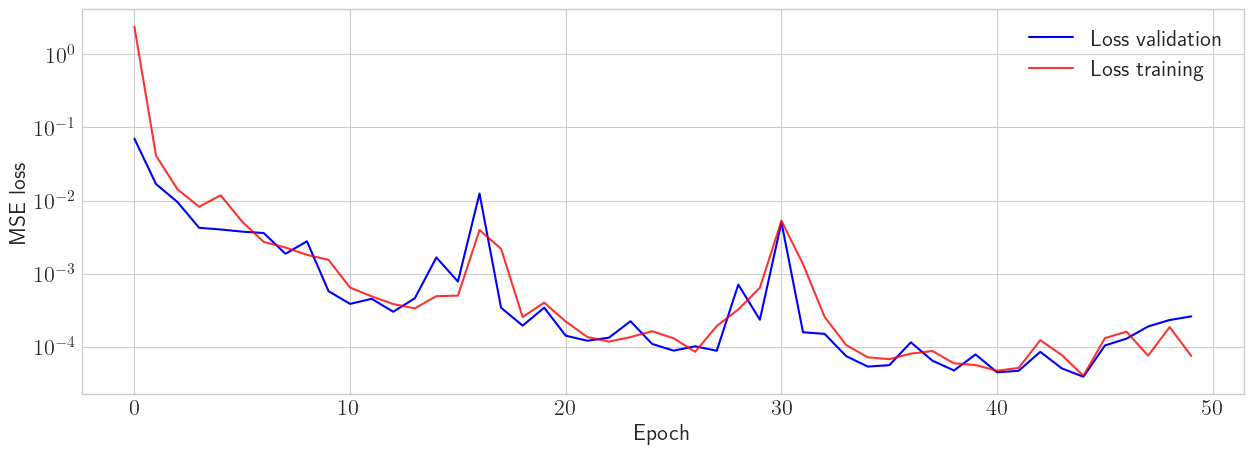

In [10]:
#print the mean squeared error over the validation dataset
print('Loss on test data is {:.3e}'.format(model.original_loss(model.model(Z01.x_scaled_test.to(model.device)).cpu().detach(), Z01.y_scaled_test)))

#plot the loss per epoch
plot.loss(model.loss_train, model.loss_test)

Show the error fraction in the 2D plot for differrent temperatures and energies, and show if points around a critical error fraction 1e-3 by having a split colorbar.

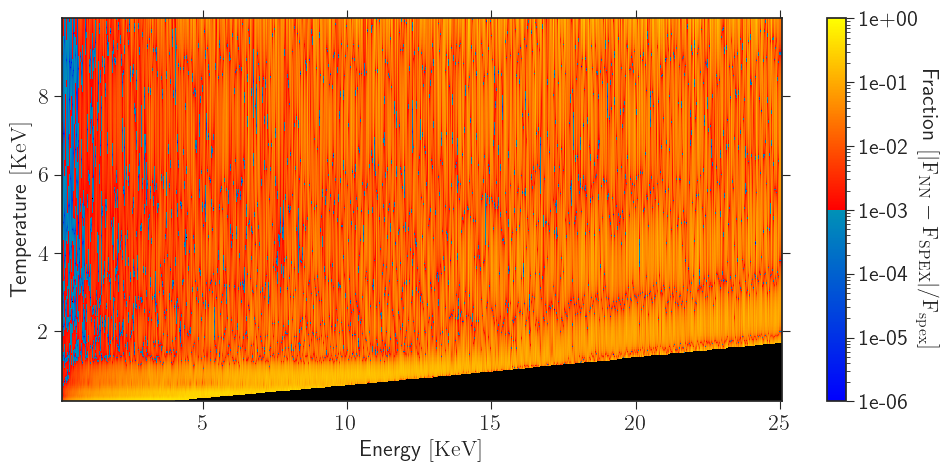

N_points above f_(10^(-3)) = 19075021; This is 44% of N_total
N_points above f_(10^(-2)) = 12670770; This is 29.2% of N_total


In [11]:
#draw predicted spectra's from the NN emulator
y_pred = Z01.power(model.predict(Z01.x_scaled_test))
y      = Z01.power(Z01.y_test, scaler=False)

#calculate error fraction between predicted spectra and validation spectra's
frac = dataloader.fraction(y_pred, y, absolute=False)

#plot the error fraction in the 2D plot for diff. temperatures and energies, and show if points around a critical error fraction 1e-3
plot.heatmap(Z01.energy, Z01.x_test, frac, Z01.mask_test, color='seismic', Z_center=-3)

Temperature is 5.002 KeV with MSE-loss of 2.113e-10


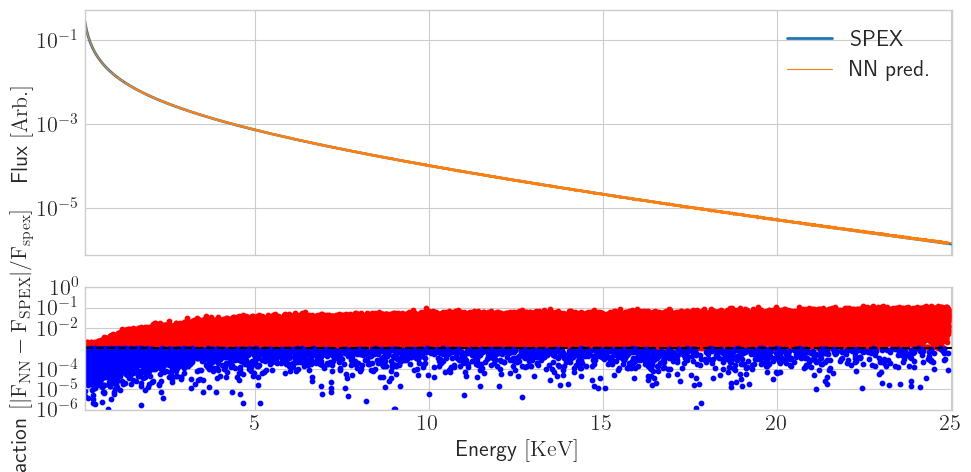

Energy of the maximum is 0.1003 [KeV]


In [12]:
#plot a spectra of spex and the spectra predicted by the NN at temperature of 5 KeV
temp = 5
plot.fraction([temp], Z01.x_test, y_pred, y, Z01.mask_test, Z01.energy)
